# Data Science in Python - COMP30760 

## Eoghan Cunningham - 16441162

# 1. Data Collection

## Chosen Stock Datasets

I have chosen to anaylyse the following datasets: 
    
    1. Apple Inc - 'http://mlg.ucd.ie/modules/COMP30760/stocks/aapl.html'
    2. Nintendo Co. - 'http://mlg.ucd.ie/modules/COMP30760/stocks/ntdoy.html'
    3. Sony Coroporation - 'http://mlg.ucd.ie/modules/COMP30760/stocks/sne.html'

In [503]:
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from datetime import datetime
import great_expectations as ge
%matplotlib inline

It can be seen from the links above that each of our datasets is associated with a different code. We can store these in the variables below.

In [504]:
apple_inc = 'aapl'
nintendo_co = 'ntdoy'
sony_corporation = 'sne'

## Scraping & Storing

Using the *Beautiful Soup* library, we can define a simple function to take these codes, request the html, parse it, and store it in a *Pandas* dataframe

In [505]:
def build_data_frame(company) : 
    
    link_string  = 'http://mlg.ucd.ie/modules/COMP30760/stocks/{}.html'
    link = link_string.format(company)
    
    source = urllib.request.urlopen(link).read()
    soup = BeautifulSoup(source,'html.parser')
    
    # find the all the tables (one for each year) and store all of their rows.
    tables = soup.find_all('table')
    table_rows = []
    for table in tables : 
        table_rows.extend(table.find_all('tr'))

    # parse the values for these rows and add them to a new list.
    rows = []
    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text for tr in td]  
        rows.append(row)
    
    # create a dataframe, removing the first row and using it to lable the columns.
    df = pd.DataFrame(rows[1:], columns=rows[0])
        
    # all NaN values in our dataframe are actually strings. We need to replace these with numpys NaN.
    return df.replace("NaN", np.nan)

Passing each of our codes as an argument to our newly defined function, we can create a dataframe for each our companies. 

Below we have small samples from each of these dataframes. 

In [506]:
sony_corporation_stocks = build_data_frame(sony_corporation)
apple_inc_stocks = build_data_frame(apple_inc)
nintendo_co_stocks = build_data_frame(nintendo_co)

apple_inc_stocks.head()

,Stock,Year,Month,Day,Open,High,Low,Close
0,AAPL,2012,01,03,58.485714,58.928570,58.428570,58.747143
1,AAPL,2012,01,04,58.571430,59.240002,58.468571,59.062859
2,AAPL,2012,01,05,59.278572,59.792858,58.952858,59.718571
3,AAPL,2012,01,06,59.967144,60.392857,59.888573,60.342857
4,AAPL,2012,01,09,60.785713,61.107143,60.192856,60.247143


# 2. Preprocessing
## Cleaning

For each company, we've taken the table for each year and created a single dataframe with all of our data. It should be noted however that the headings were repeated at the start of each table and are now repeated throughout our dataframes. 

Below we can see the different values that appear in our 'Year' column. Each year (2012 - 2018) is represented, but we can also see the label for the column must have been repeated at least once throughout our dataframe. 

In [507]:
print(nintendo_co_stocks["Year"].unique())

['2012' 'Year' '2013' '2014' '2015' '2016' '2017' '2018']


We can drop these problematic rows. Let's be sure we're not dropping any important information.

In [508]:
print("Rows Before : ",nintendo_co_stocks.shape[0], sony_corporation_stocks.shape[0], apple_inc_stocks.shape[0])

nintendo_co_stocks = nintendo_co_stocks[nintendo_co_stocks.Year != 'Year']
sony_corporation_stocks = sony_corporation_stocks[sony_corporation_stocks.Year != 'Year']
apple_inc_stocks = apple_inc_stocks[apple_inc_stocks.Year != 'Year']

print("Rows After : ", len(nintendo_co_stocks), len(sony_corporation_stocks), len(apple_inc_stocks))
print("Unique values in the year column : ",nintendo_co_stocks["Year"].unique())

Rows Before :  1765 1765 1765
Rows After :  1759 1759 1759
Unique values in the year column :  ['2012' '2013' '2014' '2015' '2016' '2017' '2018']


We can see we've dropped 6 rows from our dataframe, one for each year after 2012, and that the heading has been removed from our year column. 

## Adding Date-Time Field

We can use the *datetime* library's datetime function to store our dates instead as datetime values. 
First, we can write a function to group our 'year', 'month' and 'day' fields into a single string and pass this to the  datetime function *strptime*.

However, it can be seen from the cells below, that not all of our dataframes use the same date format. It is important to check if the strings stored in the month field are numeric before specifying the date format. 

In [509]:
print(sony_corporation_stocks["Month"].unique(),"\n",nintendo_co_stocks["Month"].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December'] 
 ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12']


In [510]:
def add_date_time(df) :
    
    # check if the month field is numeric and set the date_format appropriately.
    date_format = '%Y-%m-%d' if df['Month'][0].isnumeric() else '%Y-%B-%d'
    
    # concatinate all three strings and store them in a new column.
    df = df.assign(date_time = lambda row: (row['Year']+"-"+row['Month']+"-"+row['Day']))
    
    # apply the strptime function to update the values in our new date_time column. 
    df['date_time'] = df.apply(lambda row: datetime.strptime(row['date_time'], date_format) , axis = 1)
    
    # set this datetime field as the index 
    return df.drop(['Year', 'Month', 'Day'], axis=1 ).set_index('date_time')

In [511]:
sony_corporation_stocks = add_date_time(sony_corporation_stocks)
apple_inc_stocks = add_date_time(apple_inc_stocks)
nintendo_co_stocks = add_date_time(nintendo_co_stocks)
nintendo_co_stocks.head()

,Stock,Open,High,Low,Close
date_time,,,,,
2012-01-03,NTDOY,17.230000,17.600000,17.230000,17.510000
2012-01-04,NTDOY,17.700001,17.920000,17.700001,17.879999
2012-01-05,NTDOY,17.250000,17.660000,17.250000,17.490000
2012-01-06,NTDOY,17.309999,17.410000,17.240000,17.299999
2012-01-09,NTDOY,17.280001,17.459999,17.280001,17.410000


## Missing Values 

We can check our dataframes for missing values. 

In [512]:
print("Apple : \n",apple_inc_stocks.isna().sum(),"\n\n",\
      "Nintendo : \n",nintendo_co_stocks.isna().sum(),"\n\n",\
      "Sony : \n",sony_corporation_stocks.isna().sum())

Apple : 
 Stock      0
Open      52
High      52
Low       52
Close    119
dtype: int64 

 Nintendo : 
 Stock      0
Open      60
High      60
Low       60
Close    114
dtype: int64 

 Sony : 
 Stock       0
Open      125
High      125
Low       125
Close     125
dtype: int64


We can start by dropping any rows from our dataframes where all the prices on a given date are null.

**Why drop these rows?** 

The dataframes are already missing many rows, these rows are no different. 

Interpolating values for these rows would not change the plots produced later as the plotting function will do this interpolation, while including the interpolated values for these rows would prove misleading. 



In [513]:
def cleanup_rows(df) : 
    
    # we drop any rows for which all of our prices are null. we are also converting prices to floats and dropping the 
    # 'stock' column. 
    return df[['Open','High','Low','Close']].astype(float).dropna(how = 'all')

After using the above defined function for a bit of cleanup we can once again check for missing values.

In [514]:
aapl = cleanup_rows(apple_inc_stocks)
ntdoy = cleanup_rows(nintendo_co_stocks)
sne = cleanup_rows(sony_corporation_stocks)

print("Apple : \n",aapl.isna().sum(),"\n\n",\
      "Nintendo : \n",ntdoy.isna().sum(),"\n\n",\
      "Sony : \n",sne.isna().sum())

Apple : 
 Open      0
High      0
Low       0
Close    67
dtype: int64 

 Nintendo : 
 Open      0
High      0
Low       0
Close    54
dtype: int64 

 Sony : 
 Open     0
High     0
Low      0
Close    0
dtype: int64


It seems the only remaining null values are in our *'Close'* column. We can consider two ways to impute these values: 

1. Interpolate the values using the entire *'Close'* column

2. Use the *'high'* and *'low'* for that day/row to attempt to estimate the values. 

## Interpolating

Let's start by using the interpolate function. We can our **Nintendo** stock prices as an example, making sure to copy the dataframe so we can revert back if needed. From above, we can see that we are missing 54 prices in the *'Close'* column.

In [515]:
nintendo_example = ntdoy.copy()

#default is linear interpolation
nintendo_example['Close'] = nintendo_example['Close'].interpolate()

#check again for null values
nintendo_example.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

After interpolating these values we can see we've replaced each of the NaN vlaues with an estimation. We can check to see the quality of these values:

In [531]:
print("There are",\
      len(nintendo_example.query('Close < Low or Close > High')),\
      "rows where the close value is outside the high/low range")

There are 28 rows where the close value is outside the high/low range


Many of these estimations are outside the range of the *'High'* and *'Low'* prices for that day. This is no good.

## Imputing - Using mean values. 

Instead we will attempt to impute the missing *'Close'* values using the *'High'* and *'Low'* values.

For each complete row, we will enumerate the position of the *'Close'* value between the *'High'* and *'Low'* values.
To achieve this we caluclate $$x = {Close - Low \over High - Low}$$

For each of our stocks we will find the average x value. For example a mean value of 0.5 means that on average the *'Close'* price was halway between the *'High'* and *'Low'* values. We can then use this mean value for x to calculate our missing *'Close'* values as follows $Close = {Low + (High - Low)x}$


In [ ]:
def impute_close_prices(df) : 
    
    # drop the nulls to apply the function to only the complete rows in our dataframe, and find the mean
    # of the resulting series. 
    mean = df.dropna().apply(lambda row : (row['Close'] - row['Low'])/(row['High'] - row['Low']), axis = 1).mean()
    
    # update the close column by applying the below function whenever the value for close is nan. 
    df['Close'] = df.apply(\
                           lambda row : (row['Low'] + (row['High'] - row['Low'])*mean) if np.isnan(row['Close']) else row['Close'],\
                           axis = 1)
    
    return df

After using this function to impute missing values for our **Apple stocks**, we can use the same tests as before and can see that we have estimated a value for all of the null values.

In [518]:
aapl = impute_close_prices(aapl)
aapl.isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

and that these values all exist between the *'High'* and *'Low'* prices for that day.

In [530]:
print("There are",\
      len(aapl.query('Close < Low or Close > High')),\
      "rows where the close value is outside the high/low range")

There are 0 rows where the close value is outside the high/low range


We can do the same now with our **Nintendo stocks**

In [520]:
ntdoy = impute_close_prices(ntdoy)
print("Leaving", ntdoy.isna().sum().sum(), "missing values and", len(ntdoy.query('Close < Low or Close > High')),\
     "values outside of our acceptable range.")

Leaving 0 missing values and 0 values outside of our acceptable range.


While, at this point in time, we are not missing any values from our **Sony Corporation stocks**, this may change in the future. so we will apply the function to that dataframe also.

In [532]:
sne = impute_close_prices(sne)
print("Leaving", sne.isna().sum().sum(), "missing values and", len(sne.query('Close < Low or Close > High')),\
     "values outside of our acceptable range.")

Leaving 0 missing values and 0 values outside of our acceptable range.


# 3. Analysis

Let's begin our analysis by plotting the *'Close'* prices for each of stocks on the same graph. 

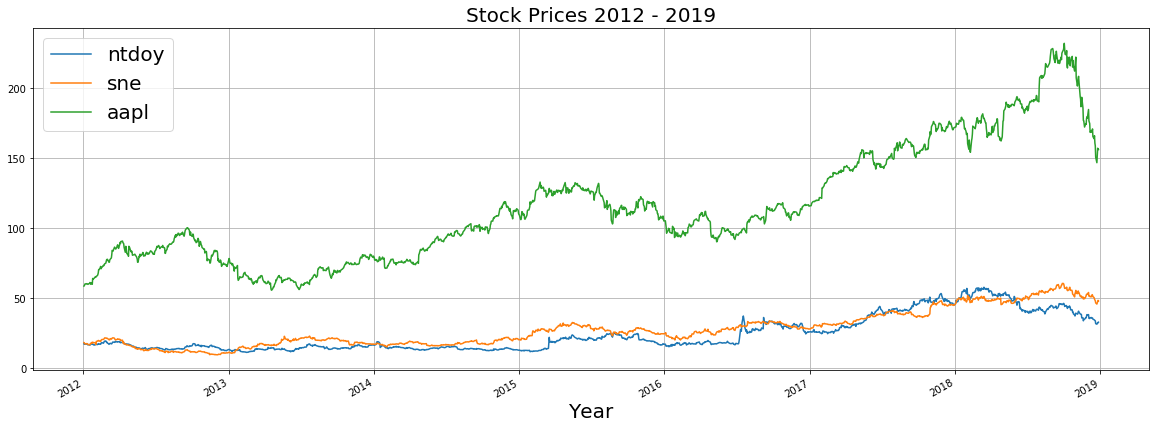

In [630]:
f = plt.figure(figsize=(20,7))
stocks = pd.DataFrame({'ntdoy': ntdoy["Close"], 'sne': sne["Close"], 'aapl': aapl["Close"]})
stocks = stocks.interpolate()
stocks.plot(ax=f.gca(),grid = True)
plt.xlabel('Year', fontsize=20)
plt.legend(prop={'size': 20})
plt.title('Stock Prices 2012 - 2019',fontsize=20)
plt.show()

We can see from the above plot that the **Apple stocks** are typically, considerably more expensive than the others. Perhaps this higher price is a reason for the **Apple stock's** greater instability or it's possible that the rises and falls of the **Apple stocks** are similar proportions to those of **Nintendo** or **Sony**

## Returns on Investment 

When comparing each of these stocks against eachother, we might choose instead to consider their **returns** over the period of the data.

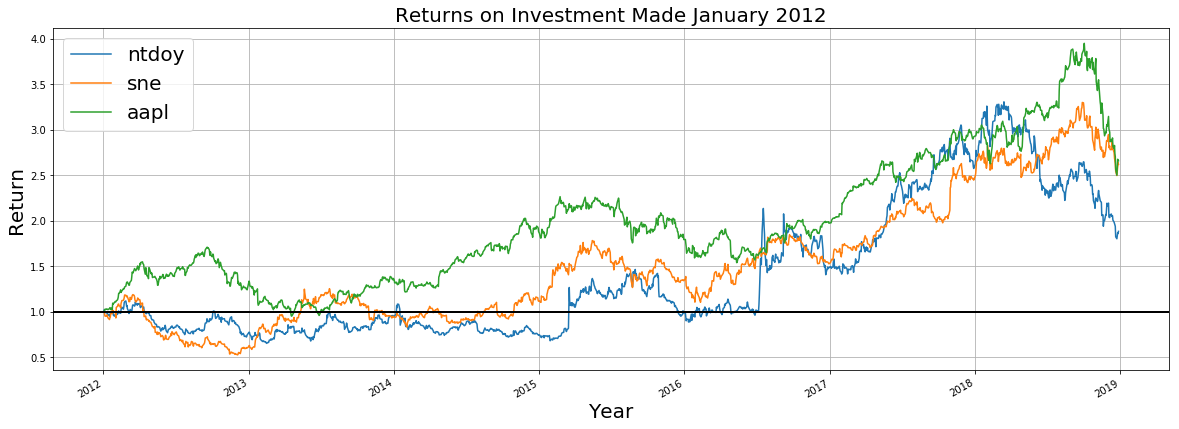

In [636]:
f = plt.figure(figsize=(20,7))
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(ax=f.gca(), grid = True).axhline(y = 1, color = "black", lw = 2)
plt.xlabel('Year', fontsize=20)
plt.legend(prop={'size': 20})
plt.ylabel('Return', fontsize=20)
plt.title('Returns on Investment Made January 2012', fontsize=20)
plt.show()

I believe this is more informative. We can now see the many periods when investing in either **Sony** or **Nintendo** yielded better returns than those of **Apple**. 

## Spikes in Prices

We can see a couple of sharp spikes in both the price and returns for **Nintendo stock** in the visualisations above. Let's consider these stocks more closely.

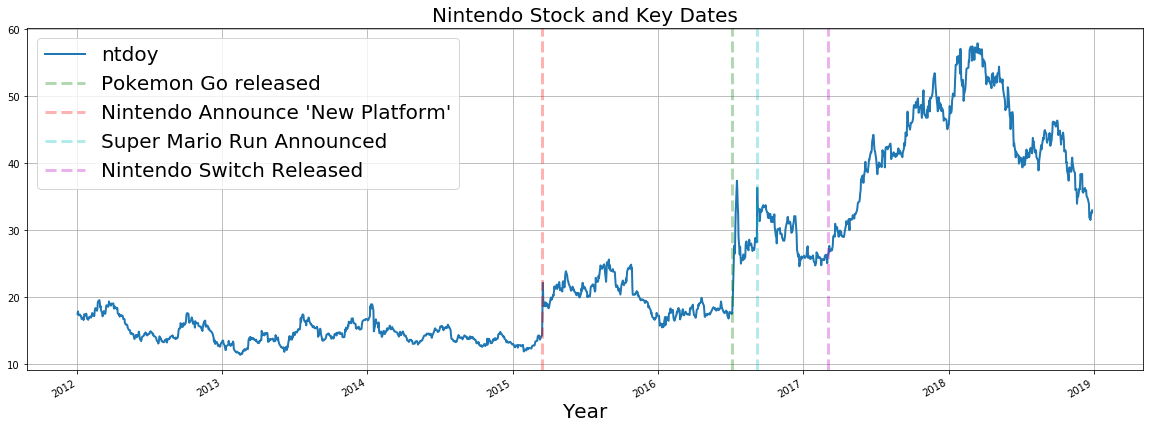

In [637]:
f = plt.figure(figsize=(20,7))
stocks['ntdoy'].plot(ax=f.gca(), grid = True,linewidth=2)
plt.axvline(x=datetime.strptime("2016-07-06", "%Y-%m-%d"), label = "Pokemon Go released",\
            color='g', linestyle='--', linewidth=3,alpha = 0.3)
plt.axvline(x=datetime.strptime("2015-03-17", "%Y-%m-%d"), label = "Nintendo Announce \'New Platform\'",\
            color='r', linestyle='--', linewidth=3,alpha = 0.3)
plt.axvline(x=datetime.strptime("2016-09-07", "%Y-%m-%d"), label = "Super Mario Run Announced",\
            color='c', linestyle='--', linewidth=3,alpha = 0.3)
plt.axvline(x=datetime.strptime("2017-03-03", "%Y-%m-%d"), label = "Nintendo Switch Released",\
            color='m', linestyle='--', linewidth=3,alpha = 0.3)
plt.legend(prop={'size': 20})
plt.xlabel('Year', fontsize=20)
plt.title('Nintendo Stock and Key Dates', fontsize=20)
plt.show()

The above visualisation illustrates the effects of product releases on the **Nintendo stock** prices. We see spikes are typically associated with product announcements. Equivalent spikes are not neccessarily apparent on the release of these products. Instead the release of the *Nintendo 'Switch'* is followed by a steady climb in the stock prices. Perhaps this climb came with the release of different games and with the long-term positive response to the console. 

Most notable of all, I believe, is the the spike in mid 2016 that coincides with the release of *'Pokemon GO'*. Prices fell considerably in the days that followed when investers learned that **Nintendo** own only a small take in the *Pokemon* company.

## Overall Trends - Rolling Averages 

We can use rolling means to consider trends in the Closing prices of our stocks. We will consider 7, 30 and 365 day overlapping periods.

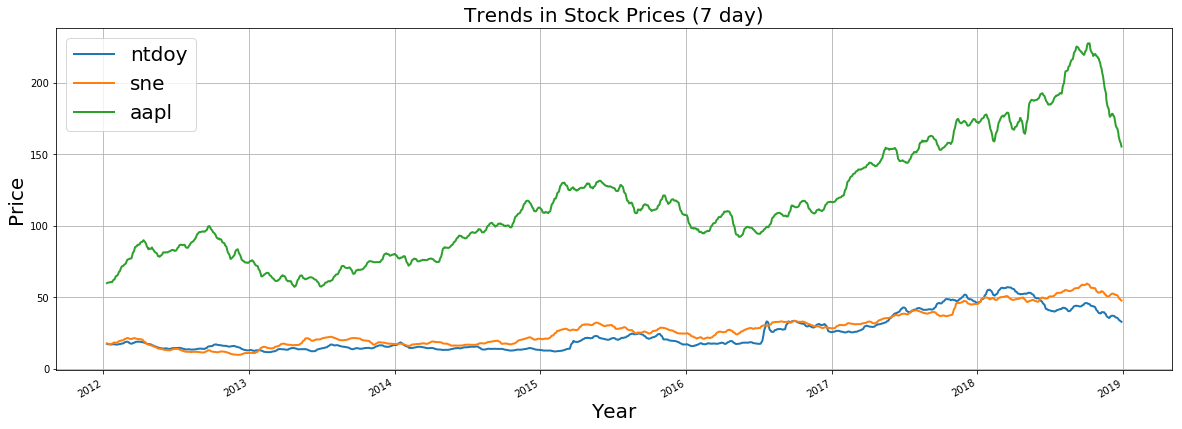

In [638]:
f = plt.figure(figsize=(20,7))
stocks.rolling(7).mean().plot(ax=f.gca(), grid = True,linewidth=2)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.legend(prop={'size': 20})
plt.title('Trends in Stock Prices (7 day)', fontsize=20)
plt.show()

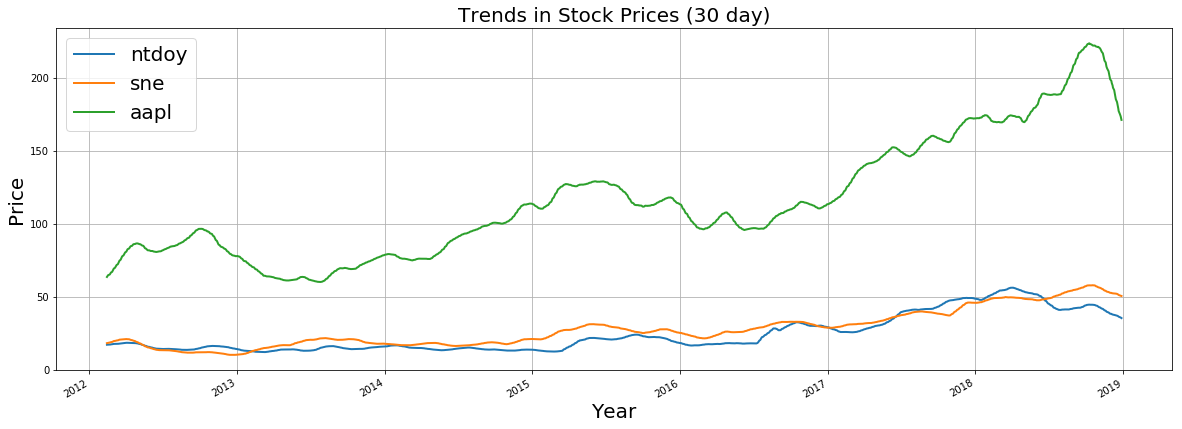

In [639]:
f = plt.figure(figsize=(20,7))
stocks.rolling(30).mean().plot(ax=f.gca(), grid = True,linewidth=2)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.legend(prop={'size': 20})
plt.title('Trends in Stock Prices (30 day)', fontsize=20)
plt.legend(prop={'size': 20})
plt.show()

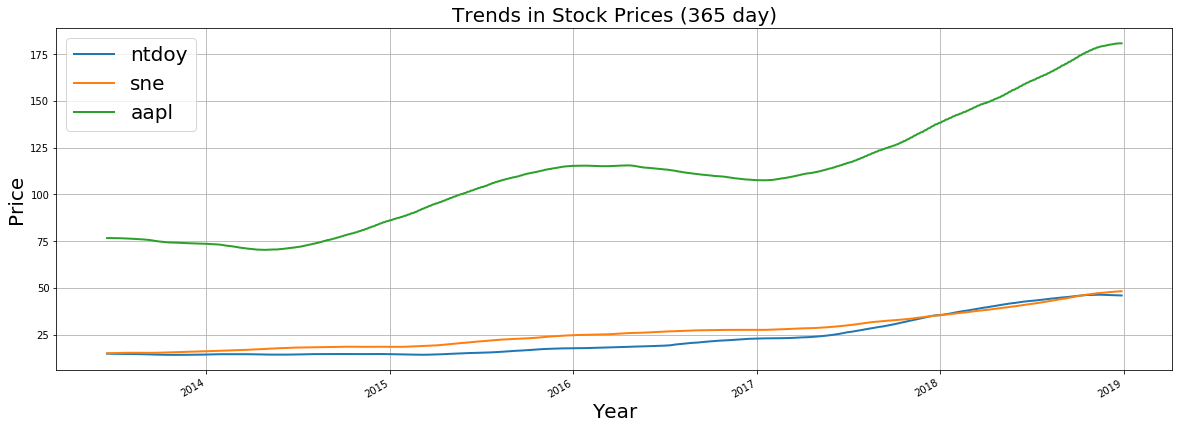

In [640]:
f = plt.figure(figsize=(20,7))
stocks.rolling(365).mean().plot(ax=f.gca(), grid = True,linewidth=2)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.legend(prop={'size': 20})
plt.title('Trends in Stock Prices (365 day)', fontsize=20)
plt.show()

The above plots show a more general trend in the closing prices of each of our stocks. 

## Seasonality - First Order Differencing

To attempt to spot any seasonality in the data we can use first order differencing to compute the difference between adjacent data points. This should remove much of the trend from our data and relieve any underlying seasonality.

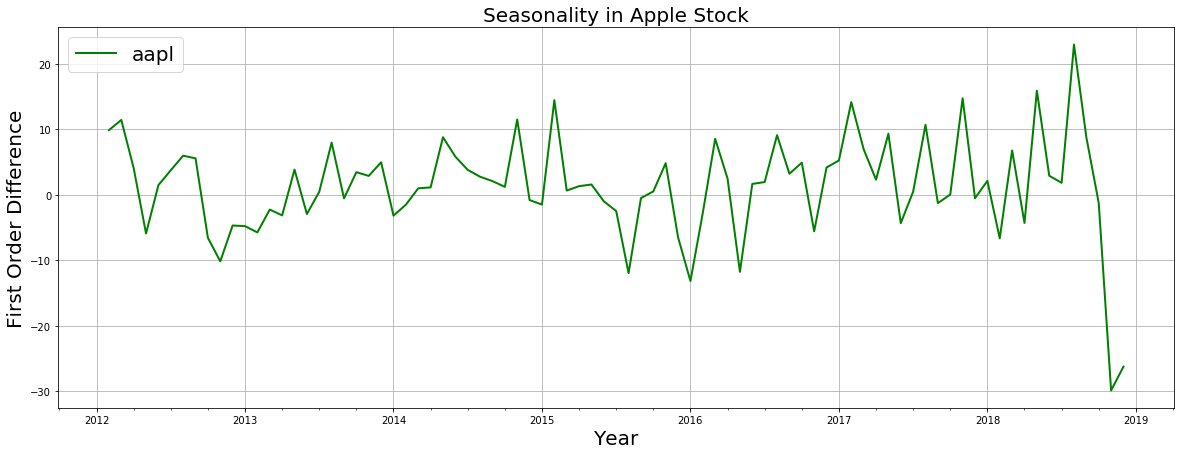

In [642]:
# resample the data on monthly intervals and plot the first order difference. 
stocks['aapl'].resample("M").mean().diff().plot(figsize=(20,7), grid = True,color = 'g',linewidth=2)
plt.legend(prop={'size': 20})
plt.xlabel('Year', fontsize=20)
plt.ylabel('First Order Difference', fontsize=20)
plt.legend(prop={'size': 20})
plt.title('Seasonality in Apple Stock', fontsize=20)
plt.show()

There is little to no seasonality visible in the **Apple** stock prices. I find this somewhat surprising given that *iPhones* are typically released 11-13 months after the previous model and based on our analysis of the **Nintendo** stocks one might assume such products had an influence on stock prices. 